## Import data

In [ ]:
import pandas as pd # pyright: ignore[reportMissingModuleSource]

df = pd.read_csv("data.csv", sep=";")
print(df.shape)  # dimensions
print(df.info())  # types and missing values
print(df.head())  # 5 first lines

(55074, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55074 entries, 0 to 55073
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email       55074 non-null  object
 1   EMG1        55074 non-null  int64 
 2   EMG2        55074 non-null  int64 
 3   EMG3        55074 non-null  int64 
 4   EMG4        55074 non-null  int64 
 5   EMG5        55074 non-null  int64 
 6   EMG6        55074 non-null  int64 
 7   EMG7        55074 non-null  int64 
 8   EMG8        55074 non-null  int64 
 9   Framecount  55074 non-null  int64 
 10  gesture     55074 non-null  object
 11  SessionID   55074 non-null  object
 12  Timestamp   55074 non-null  object
dtypes: int64(9), object(4)
memory usage: 5.5+ MB
None
       Email  EMG1  EMG2  EMG3  EMG4  EMG5  EMG6  EMG7  EMG8  Framecount  \
0  anonymous    -7     5    -6    -8    -4    -1    10    16           2   
1  anonymous   -14    -3     0     0     7     4   -20    -2           2

## Clean data
### Manage missing data

In [ ]:
df = df.drop_duplicates()  # remove duplicate rows
df = df.dropna() # remove rows with missing values

### Standardize data

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler # pyright: ignore[reportMissingModuleSource]


# Standardization
scaler = StandardScaler()
standard_data = scaler.fit_transform(df[emg_cols])

print("Standardized EMG columns:")
print(standard_data[:5])

# Label Encoding
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['gesture'])
print("\nEncoded labels:")
print(df[['label', 'gesture']].drop_duplicates())

Standardized EMG columns:
[[-0.12252981  0.21856796 -0.40192204 -0.21103731 -0.4638605  -0.01788108
   1.04133191  1.44975349]
 [-0.62790529 -0.10624188  0.0786184   0.61118801  1.20198524  0.75184117
  -1.67282058 -0.09351802]
 [ 0.45504217 -0.10624188  0.23879854  0.20007535 -2.12970624 -1.86521447
   0.04614266  0.33516851]
 [ 0.59943517 -0.02503942  0.79942906  1.33063516  1.20198524  0.13606337
   0.40802966  0.33516851]
 [ 0.31064918  1.0711938   0.71933898  0.50840984 -0.91818206 -0.01788108
   1.13180366  0.84959235]]

Encoded labels:
       label        gesture
0          0           fist
6474       1          pinch
14788      2           rest
26702      3     wrist-back
40248      4  wrist-forward


### Split data

In [ ]:
from sklearn.model_selection import train_test_split

# Use the cleaned and prepared dataframe from previous cells
# Separate features (X) and labels (y)
emg_cols = ['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8']
X = standard_data
y = df['label']

# 3. Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Baseline model
### Search best hyperparameter

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define model
search_model = DecisionTreeClassifier(random_state=42)

# Define parameter grid
param_grid = {
    "max_depth": [2, 4, 6, 8, 10, None],
    "criterion": ["gini", "entropy"]
}

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(search_model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best validation accuracy:", grid_search.best_score_)


Best parameters: {'criterion': 'entropy', 'max_depth': 10}
Best validation accuracy: 0.8134679667448307


### Train model

In [6]:
# 4. Train a simple Decision Tree
model = DecisionTreeClassifier(random_state=42, criterion=grid_search.best_params_["criterion"], max_depth=grid_search.best_params_["max_depth"])
model.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

## Evaluation

Validation accuracy: 0.8110398256869629
              precision    recall  f1-score   support

           0       0.68      0.44      0.53       997
           1       0.66      0.77      0.71      1288
           2       0.86      0.94      0.90      1752
           3       0.86      0.80      0.83      2048
           4       0.87      0.91      0.89      2176

    accuracy                           0.81      8261
   macro avg       0.79      0.77      0.77      8261
weighted avg       0.81      0.81      0.81      8261

Cross-validation scores: [0.79007864 0.78510896 0.78026634 0.77663438 0.77663438]
Mean accuracy: 0.7817445425369385


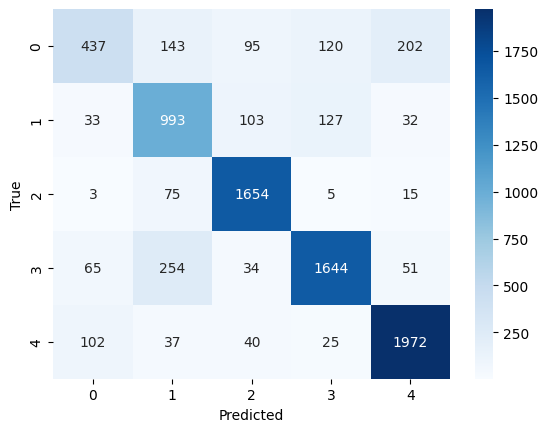

[[0.01309478 0.01892908 0.95060288 0.00842733 0.00894594]
 [0.0952381  0.02721088 0.         0.0170068  0.86054422]
 [0.02232143 0.         0.         0.         0.97767857]
 [0.06030151 0.33165829 0.         0.06532663 0.54271357]
 [0.01309478 0.01892908 0.95060288 0.00842733 0.00894594]]


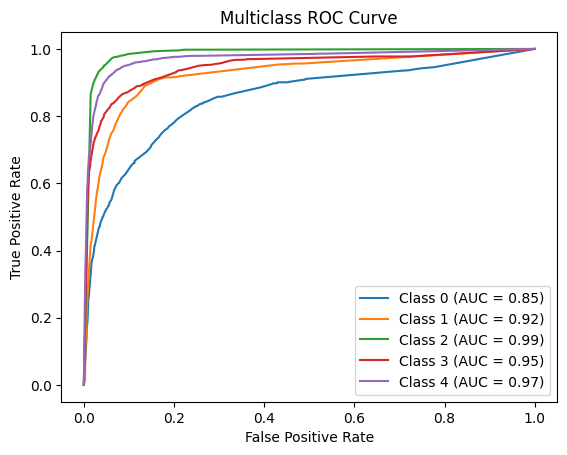

In [7]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_val, y_val):
    # Evaluate on validation set
    y_pred = model.predict(X_val)
    print("Validation accuracy:", accuracy_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
	
    # Cross-validation
    scores = cross_val_score(model, X_val, y_val, cv=5)
    print("Cross-validation scores:", scores)
    print("Mean accuracy:", scores.mean())


    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


    # Predict probabilities for the first 5 samples in the validation set
    probs = model.predict_proba(X_val[:5])
    print(probs)


    # ROC Curve
    y_val_bin = label_binarize(y_val, classes=model.classes_)
    probs_full = model.predict_proba(X_val)

    plt.figure()
    for i in range(y_val_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], probs_full[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend()
    plt.show()

evaluate_model(model, X_val, y_val)


## Artificial Neural Network

Training improved neural network...
Training completed!
Number of iterations: 173
Final loss: 0.2821

=== IMPROVED NEURAL NETWORK RESULTS ===
Validation accuracy: 0.8873017794455877
              precision    recall  f1-score   support

           0       0.79      0.67      0.72       997
           1       0.83      0.82      0.82      1288
           2       0.94      0.98      0.96      1752
           3       0.88      0.90      0.89      2048
           4       0.92      0.95      0.93      2176

    accuracy                           0.89      8261
   macro avg       0.87      0.86      0.87      8261
weighted avg       0.88      0.89      0.89      8261

Cross-validation scores: [0.86690865 0.86743341 0.87046005 0.85835351 0.86198547]
Mean accuracy: 0.8650282192916541


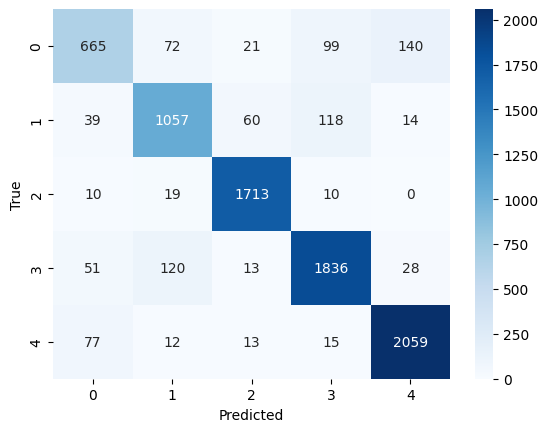

[[1.18838011e-03 4.37969331e-02 9.51971610e-01 2.19607851e-03
  8.46997783e-04]
 [9.33157848e-03 2.84776685e-07 5.17656883e-11 3.95754899e-05
  9.90628561e-01]
 [2.17841779e-03 1.39347879e-05 2.97870738e-10 1.71057129e-05
  9.97790541e-01]
 [1.10519813e-01 2.40585320e-01 1.77249213e-03 4.16480731e-02
  6.05474301e-01]
 [3.95516816e-04 8.73977020e-03 9.89900017e-01 5.49378171e-04
  4.15318265e-04]]


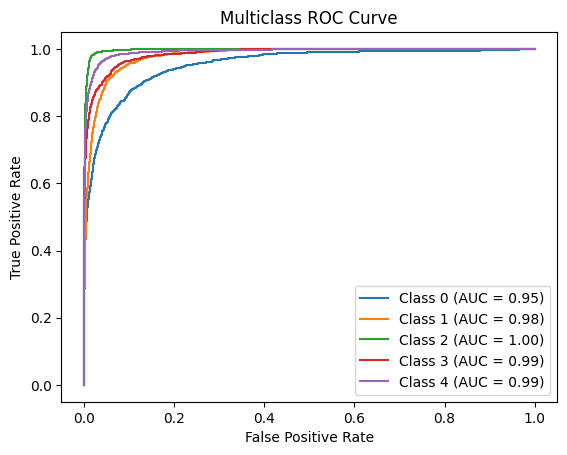

In [8]:
from sklearn.neural_network import MLPClassifier

def create_mlp_model(hidden_layer_sizes, activation, alpha, learning_rate_init):
    return MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver='adam',
        alpha=alpha,                                    # L2 regularization
        learning_rate_init=learning_rate_init,
        max_iter=2000,
        validation_fraction=0.2,                        # Use 20% of training data for validation
        early_stopping=True,                            # Stop when validation score stops improving
        n_iter_no_change=50,                            # Stop after 50 iterations without improvement
        random_state=42,
        batch_size='auto'
    )

mlp = create_mlp_model(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    alpha=0.001,
    learning_rate_init=0.001,
)

print("Training improved neural network...")
mlp.fit(X_train, y_train)

print("Training completed!")
print(f"Number of iterations: {mlp.n_iter_}")
print(f"Final loss: {mlp.loss_:.4f}")

# Evaluate the improved model
print("\n=== IMPROVED NEURAL NETWORK RESULTS ===")
evaluate_model(mlp, X_val, y_val)

## Hyperparameter optimization

C:\Users\stud\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-20 11:38:00,480] A new study created in memory with name: no-name-99d8278d-b8bb-43b4-b0d2-9f09d5d8d3cd
[I 2025-08-20 11:38:08,987] Trial 0 finished with value: 0.8829862089895754 and parameters: {'hidden_layer_sizes': '64', 'activation': 'relu', 'alpha': 0.009841793964819419, 'learning_rate_init': 0.00196435225673374}. Best is trial 0 with value: 0.8829862089895754.
[I 2025-08-20 11:38:24,371] Trial 1 finished with value: 0.8841535201275802 and parameters: {'hidden_layer_sizes': '64-32', 'activation': 'tanh', 'alpha': 0.0003150136093661409, 'learning_rate_init': 0.002035266627608373}. Best is trial 1 with value: 0.8841535201275802.
[I 202

Top 5 trials:
        value params_hidden_layer_sizes params_activation  params_alpha  \
9   0.890172                    128-64              relu      0.004194   
8   0.888122                    128-64              relu      0.000584   
12  0.887370                    128-64              relu      0.000667   
14  0.887240                    128-64              relu      0.008331   
13  0.887214                    128-64              relu      0.000835   

    params_learning_rate_init  
9                    0.001325  
8                    0.000533  
12                   0.005431  
14                   0.006320  
13                   0.000556  


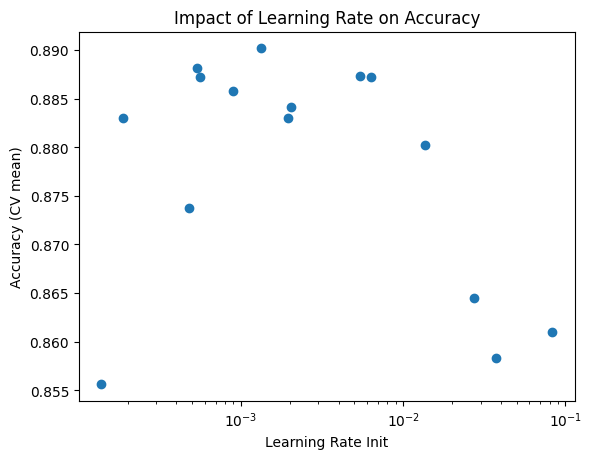

In [9]:
import optuna

def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', ['32', '64', '64-32', '128-64'])
    layer_map = {
        '32': (32,),
        '64': (64,),
        '64-32': (64, 32),
        '128-64': (128, 64)
    }
    hidden_layer_sizes = layer_map[hidden_layer_sizes]

    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=2000,
        early_stopping=True,
        random_state=42
    )

    scores = cross_val_score(mlp, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# -------------------------------
# 📊 Step 12.1 - Results Analysis
# -------------------------------
# Convert trials to a DataFrame
df_results = study.trials_dataframe()

# Sort by best accuracy
df_sorted = df_results.sort_values('value', ascending=False)
print("Top 5 trials:\n", df_sorted[['value', 'params_hidden_layer_sizes', 
                                    'params_activation', 'params_alpha', 
                                    'params_learning_rate_init']].head())

# -------------------------------
# 📈 Step 12.2 - Visualization
# -------------------------------
# Plot accuracy vs learning rate
plt.scatter(df_results['params_learning_rate_init'], df_results['value'])
plt.xscale('log')
plt.xlabel("Learning Rate Init")
plt.ylabel("Accuracy (CV mean)")
plt.title("Impact of Learning Rate on Accuracy")
plt.show()


Best parameters: {'hidden_layer_sizes': '128-64', 'activation': 'relu', 'alpha': 0.004194190427773294, 'learning_rate_init': 0.0013245566340965081}
Training improved neural network...
Training completed!
Number of iterations: 75
Final loss: 0.2463

=== IMPROVED NEURAL NETWORK RESULTS ===
Validation accuracy: 0.8932332647379252
              precision    recall  f1-score   support

           0       0.80      0.70      0.74       997
           1       0.82      0.84      0.83      1288
           2       0.94      0.98      0.96      1752
           3       0.90      0.89      0.90      2048
           4       0.93      0.95      0.94      2176

    accuracy                           0.89      8261
   macro avg       0.88      0.87      0.87      8261
weighted avg       0.89      0.89      0.89      8261

Cross-validation scores: [0.87598306 0.87227603 0.87772397 0.87046005 0.87288136]
Mean accuracy: 0.8738648930918764


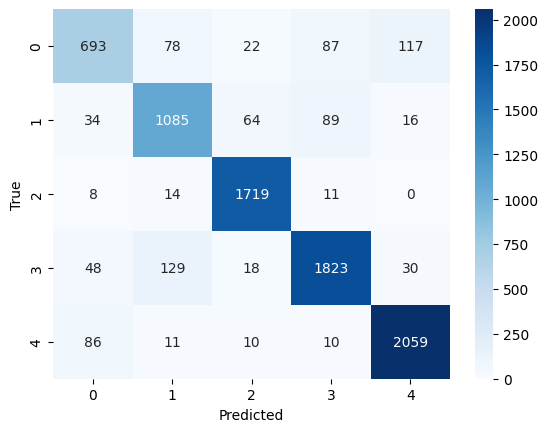

[[9.72397439e-04 1.39350778e-02 9.83851681e-01 1.04196384e-03
  1.98879544e-04]
 [1.76476313e-03 8.18017399e-07 3.47569571e-10 1.13759666e-04
  9.98120659e-01]
 [5.28685367e-04 2.50755155e-07 3.34759924e-13 7.65226409e-07
  9.99470299e-01]
 [4.00561007e-02 1.60933052e-01 7.89123586e-04 7.52976135e-02
  7.22924111e-01]
 [6.21293887e-04 5.49667135e-03 9.93406797e-01 2.93761172e-04
  1.81476283e-04]]


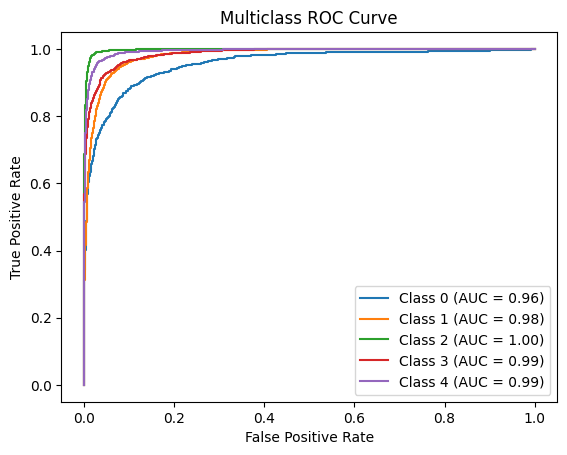


============== Test Accuracy: 0.8995400629387558 ==============
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       997
           1       0.82      0.86      0.84      1226
           2       0.93      0.97      0.95      1773
           3       0.90      0.91      0.90      2016
           4       0.94      0.95      0.95      2250

    accuracy                           0.90      8262
   macro avg       0.88      0.88      0.88      8262
weighted avg       0.90      0.90      0.90      8262



In [10]:
# Train the best model on full training set
best_params = study.best_trial.params
print("Best parameters:", best_params)

layers = [int(x) for x in best_params['hidden_layer_sizes'].split('-')]
best_mlp = create_mlp_model(
    hidden_layer_sizes=layers,
    activation=best_params['activation'],
    alpha=best_params['alpha'],
    learning_rate_init=best_params['learning_rate_init'],
)

print("Training improved neural network...")
best_mlp.fit(X_train, y_train)

print("Training completed!")
print(f"Number of iterations: {best_mlp.n_iter_}")
print(f"Final loss: {best_mlp.loss_:.4f}")

# Evaluate the improved model
print("\n=== IMPROVED NEURAL NETWORK RESULTS ===")
evaluate_model(best_mlp, X_val, y_val)

# Evaluate on test set
y_pred = best_mlp.predict(X_test)
print("\n============== Test Accuracy:", accuracy_score(y_test, y_pred), "==============")
print(classification_report(y_test, y_pred))


### Model export

In [11]:
# train_export.py
import json
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from datetime import datetime

FEATURE_NAMES = emg_cols  # Use the original EMG column names
CLASS_NAMES = encoder.classes_.tolist()



df = pd.read_csv("data.csv", sep=";")
df = df.drop_duplicates()  # remove duplicate rows
df = df.dropna() # remove rows with missing values



# Separate features and labels
X = df[emg_cols]

# Label Encoding
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['gesture'])
print("\nEncoded labels:")
print(df[['label', 'gesture']].drop_duplicates())
Y = df['label']



X_train, X_eval, y_train, y_eval = train_test_split(X, Y, test_size=0.3, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", create_mlp_model(
        hidden_layer_sizes=layers,
        activation=best_params['activation'],
        alpha=best_params['alpha'],
        learning_rate_init=best_params['learning_rate_init'],
    ))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_eval)

metrics = {
    "accuracy": float(accuracy_score(y_eval, y_pred)),
    "report": classification_report(y_eval, y_pred, target_names=CLASS_NAMES, output_dict=True),
}

timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
model_dir = f"models/gesture_cls/1.0.0_{timestamp}"
os.makedirs(model_dir, exist_ok=True)

# 1) Save pipeline
joblib.dump(pipe, f"{model_dir}/pipeline.joblib")

# 2) Save config (schema, classes, thresholds, etc.)
config = {
    "feature_names": FEATURE_NAMES,
    "class_names": CLASS_NAMES,
    "top_k": 2,
    "abstain_threshold": 0.6,  # below this max prob => "unknown"
    "random_state": 42,
    "library": {"sklearn": ">=1.2"},
}
with open(f"{model_dir}/config.json", "w") as f:
    json.dump(config, f, indent=2)

# 3) Save metrics
with open(f"{model_dir}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Model exported to:", model_dir)



Encoded labels:
       label        gesture
0          0           fist
6474       1          pinch
14788      2           rest
26702      3     wrist-back
40248      4  wrist-forward
Model exported to: models/gesture_cls/1.0.0_20250820T094320Z
